# Comprehensive Mapping of HIV-1 Escape from a Broadly Neutralizing Antibody
### Adam S. Dingens, Hugh K. Haddox, Julie Overbaugh, and Jesse D. Bloom

### Mutational antigenic profiling the PGT151 bnAb using BF520 Env.
These experiments map how mutations to the Env of the BF520 strain of HIV affect neutralization by the broadly neutralizing antibody PGT151.

Experiments performed by Adam Dingens in the [Bloom lab](http://research.fhcrc.org/bloom/en.html) in the autumn of 2016. This analysis has been published in [Cell Host & Microbe](http://dx.doi.org/10.1016/j.chom.2017.05.003) in June 2017. This additional analysis was performed on the same data in Sept 2017. 

Originally, this analysis was performed using [dms_tools](http://jbloomlab.github.io/dms_tools/). This original analysis is located [in this ipython notebook](https://github.com/adingens/BF520_MutationalAntigenicProfiling_PGT151). 

Here, we will redo this analysis  using the [dms_tools2](https://jbloomlab.github.io/dms_tools2/). Similarly to the original analysis, we this notebook processes the Illumina deep sequencing data software package, and then analyzes the selection in the context of the antibody. Again, it is a stripped down analysis that focuses on the key analyses relevant to the final manuscript.
Because of use of the newer software package, the results of this re-analyis may not exactly match those in the orignal study, but they will be very close.

## Import `Python` modules, define widely used functions
Set `use_existing` to `yes` below if you want to use any existing output, and `no` if you want to re-generate all output.

In [1]:
import os
import glob
import pandas
from IPython.display import display, HTML
import dms_tools2
import dms_tools2.plot
import dms_tools2.sra
import dms_tools2.utils
from dms_tools2.ipython_utils import showPDF

print("Using dms_tools2 version {0}".format(dms_tools2.__version__))

# results will go in this directory
resultsdir = './results/' 
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)
    
# CPUs to use, -1 means all available
ncpus = -1

# do we use existing results or generate everything new?
use_existing = 'yes'

/usr/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  return f(*args, **kwds)


Using dms_tools2 version 2.0a0


## Download the sequencing data from the Sequence Read Archive
The deep sequencing reads reads were submitted [Sequence Read Archive](http://www.ncbi.nlm.nih.gov/sra) submission SUB2392015 and they all have the BioSample Accession number SAMN06313000 on Feb 9, 2017. The BioProject ID is [PRJNA371844](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA371844/).

We download these files using the [dms_tools2.sra.fastqFromSRA](https://jbloomlab.github.io/dms_tools2/dms_tools2.sra.html#dms_tools2.sra.fastqFromSRA) function from the [dms_tools2 Python API](https://jbloomlab.github.io/dms_tools2/api.html).
Note that the call to this function below uses two external programs that are **not** part of [dms_tools2](https://jbloomlab.github.io/dms_tools2/index.html), and which you therefore must install externally on the computer that you are using:
1. The [fastq-dump](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=fastq-dump) program from the [SRA Toolkit](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc). If you do not already have this toolkit installed, you will need to install it by [following these instructions](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=std). You need a relatively recent version.
2. The [Aspera Connect](https://www.ncbi.nlm.nih.gov/books/NBK242625/) program for rapid downloads. You need both the executable `ascp` and an Aspera Key file. Installing Aspera Connect and a key can be somewhat complex, so if you do not want to do this then just set `aspera=None` in the command below and `fastq-dump` will do the downloads (albeit more slowly).

The samples are the mutant DNA libraries (*mutDNA*), the wildtype DNA error control (*wtDNA*), the wildtype virus controls (*wtvirus*) and the mock and PGT151 selected mutant virus samples.
There are three replicates of all except for the *wtDNA* control.

In [2]:
samples = pandas.DataFrame.from_records(
        [('mutDNA-1', 'SRR5241726'),
         ('mutDNA-2', 'SRR5241725'),
         ('mutDNA-3', 'SRR5241724'),
         ('mock-1', 'SRR5241723'),
         ('PGT151-1', 'SRR5241722'),
         ('mock-2', 'SRR5241721'),
         ('PGT151-2', 'SRR5241720'),
         ('mock-3', 'SRR5241719'),
         ('PGT151-3', 'SRR5241718'),
         ('wtDNA', 'SRR5241717'),
         ('wtvirus-1', 'SRR5241716'),
         ('wtvirus-2', 'SRR5241715'),
         ('wtvirus-3', 'SRR5241714')],       
        columns=['name', 'run']
        )

fastqdir = os.path.join(resultsdir, './FASTQ_files/')
print("Downloading FASTQ files from the SRA...")
dms_tools2.sra.fastqFromSRA(
        samples=samples,
        fastq_dump='fastq-dump', # valid path to this program on the Hutch server
        fastqdir=fastqdir,
        aspera=(
            '/app/aspera-connect/3.5.1/bin/ascp', # valid path to ascp on Hutch server
            '/app/aspera-connect/3.5.1/etc/asperaweb_id_dsa.openssh' # Aspera key on Hutch server
            )
        )
print("Here are the names of the downloaded files now found in {0}".format(fastqdir))
display(HTML(samples.to_html(index=False)))

Here are the names of the downloaded files now found in ./results/./FASTQ_files/


name,run,R1,R2
mutDNA-1,SRR5241726,mutDNA-1_R1.fastq.gz,mutDNA-1_R2.fastq.gz
mutDNA-2,SRR5241725,mutDNA-2_R1.fastq.gz,mutDNA-2_R2.fastq.gz
mutDNA-3,SRR5241724,mutDNA-3_R1.fastq.gz,mutDNA-3_R2.fastq.gz
mock-1,SRR5241723,mock-1_R1.fastq.gz,mock-1_R2.fastq.gz
PGT151-1,SRR5241722,PGT151-1_R1.fastq.gz,PGT151-1_R2.fastq.gz
mock-2,SRR5241721,mock-2_R1.fastq.gz,mock-2_R2.fastq.gz
PGT151-2,SRR5241720,PGT151-2_R1.fastq.gz,PGT151-2_R2.fastq.gz
mock-3,SRR5241719,mock-3_R1.fastq.gz,mock-3_R2.fastq.gz
PGT151-3,SRR5241718,PGT151-3_R1.fastq.gz,PGT151-3_R2.fastq.gz
wtDNA,SRR5241717,wtDNA_R1.fastq.gz,wtDNA_R2.fastq.gz


## Process the FASTQ files to count the mutations for each sample
[Dingens et al. 2017](http://dx.doi.org/10.1016/j.chom.2017.05.003) used [barcoded-subamplicon](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) sequencing to obtain high accuracy during the Illumina deep sequencing. We therefore use the [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html#dms2-batch-bcsubamp) program to analyze these data.

Running that program requires specifying a `--batchfile` that lists the samples, a wildtype `--refseq` to which we make alignments, and --alignspecs that tell us where the subamplicons should align. 
The batch file that we specify is printed by the cell below. 
The alignments are made to the wildtype BF520.W14.C2 env coding sequence described above. 
The alignment specs are specified based on the exact primers used for the barcoded-subamplicon sequencing by [Dingens et al. 2017](http://dx.doi.org/10.1016/j.chom.2017.05.003). 
The alignment specs need to be exactly correct for the subamplicons to align.

We also do some trimming of the reads using the `--R1trim` and `--R2trim` parameters. 
Such trimming can be crucial for getting good results, since the read quality often drops off at the end of reads. 
Below, we have trimmed all subamplicons equally, but in some cases you might want to trim each one differently by specifying a list of values for each subamplicon.

The wildtype sequence of the BF520 Env used in this experiment is in the file [./data/BF520c2-Env.fasta](./data/BF520c2-Env.fasta).
This sequence is available on GenBank as accession number [KX168094.1](https://www.ncbi.nlm.nih.gov/nuccore/KX168094.1).

In [3]:
refseq = './data/BF520c2-Env.fasta'

# define subamplicon alignment specifications
alignspecs = ' '.join(['88,417,40,39', 
                       '418,753,39,35',
                       '754,1092,36,39',
                       '1093,1447,35,29',
                       '1407,1758,35,32',
                       '1759,2097,30,36'])

# counts and alignments placed in this directory
countsdir = os.path.join(resultsdir, 'codoncounts')
if not os.path.isdir(countsdir):
    os.mkdir(countsdir)
    
# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(samples[['name', 'R1']].to_html(index=False)))
samples[['name', 'R1']].to_csv(countsbatchfile, index=False)

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 205 \
        --R2trim 212 \
        --fastqdir {fastqdir} \
        --ncpus {ncpus} \
        --use_existing {use_existing} 
print("Completed dms2_batch_bcsubamp.")

Here is the batch file that we write to CSV format to use as input:


name,R1
mutDNA-1,mutDNA-1_R1.fastq.gz
mutDNA-2,mutDNA-2_R1.fastq.gz
mutDNA-3,mutDNA-3_R1.fastq.gz
mock-1,mock-1_R1.fastq.gz
PGT151-1,PGT151-1_R1.fastq.gz
mock-2,mock-2_R1.fastq.gz
PGT151-2,PGT151-2_R1.fastq.gz
mock-3,mock-3_R1.fastq.gz
PGT151-3,PGT151-3_R1.fastq.gz
wtDNA,wtDNA_R1.fastq.gz



Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


Now we look at the summary plots created by `dms2_batch_bcsubamp`. 
All of these files are found in the directory specified by --outdir, and with the prefix specified by summaryprefix. 
So we define them using this plot prefix plus the suffix for each plot.
Note that these files all refer to sites in sequential 1, 2, ... numbering of the BF520 sequence.

In [4]:
countsplotprefix = os.path.join(countsdir, 'summary')

The `*_readstats.pdf` plot below shows the statistics on the reads. This plot shows that most of the reads were retained, and a small fraction discarded because of low-quality barcodes. None failed the Illumina filter as those were already filtered out those when we downloaded from the SRA.

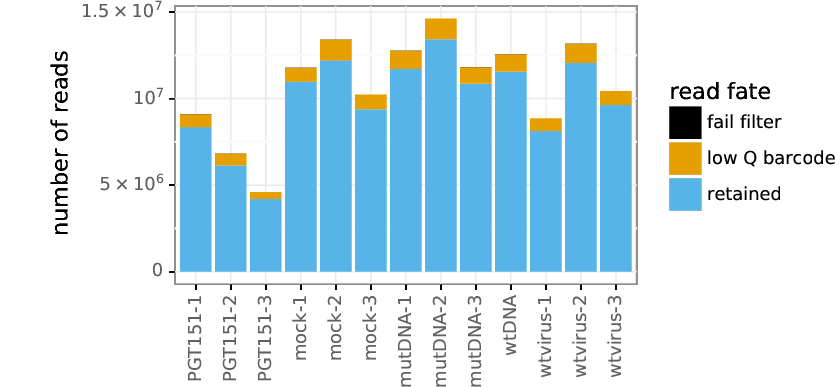

In [5]:
showPDF(countsplotprefix + '_readstats.pdf', width=600)

The `*_readsperbc.pdf` plot below shows how many times different barcodes were observed for each sample. Barcodes need to be observed multiple times to be useful for barcoded-subamplicon sequencing error correction.

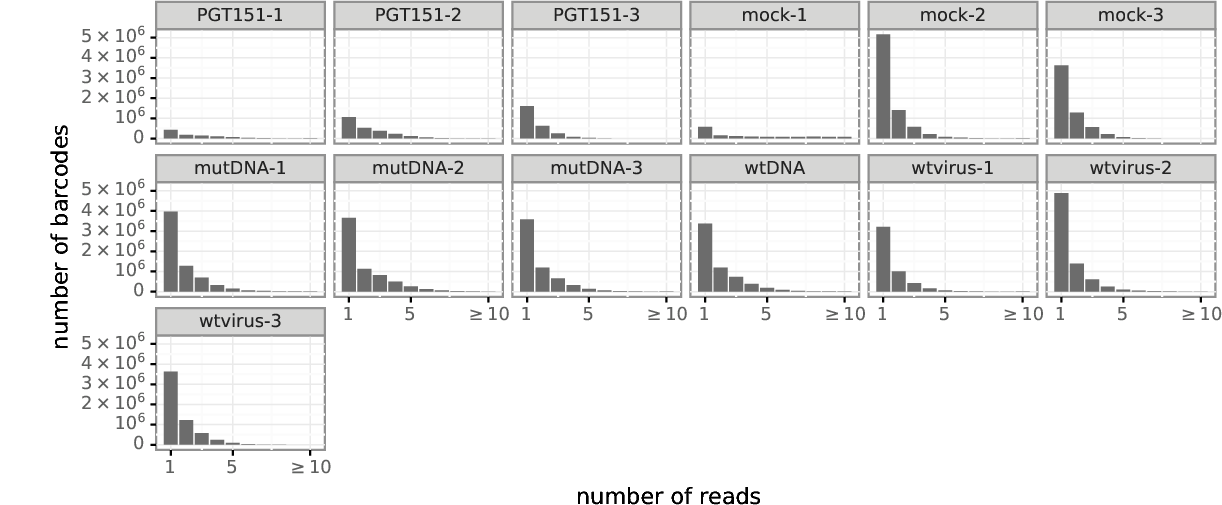

In [6]:
showPDF(countsplotprefix + '_readsperbc.pdf')

The `*_bcstats.pdf` plot below shows statistics on the barcodes. Some of the barcodes had to be discarded because they had too few reads (these are the single-read barcodes in the plot above), a small fraction with adequate reads were not alignable, and the rest aligned to the Env gene properly.
This plot and the one above suggest that probably could have gotten additional depth by sequencing more, since then we would have had more barcodes with multiple reads.

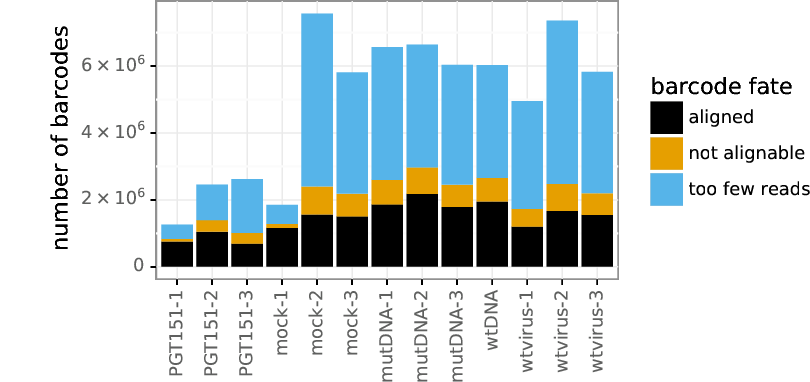

In [7]:
showPDF(countsplotprefix + '_bcstats.pdf', width=600)

The `*_depth.pdf` plot below shows the depth (number of called codons) at each site in the gene. 
For most of the samples, the depth across the gene is fairly uniform, indicating that the subamplicons were pooled fairly evenly.  
Note that some samples (in particular the mock samples) were intentionally sequenced to higher depth than the antibody-selected samples, as we expect to see more diversity in the mock samples. 
Note that the gene was not sequenced past codon site 691, and so there is no coverage there.

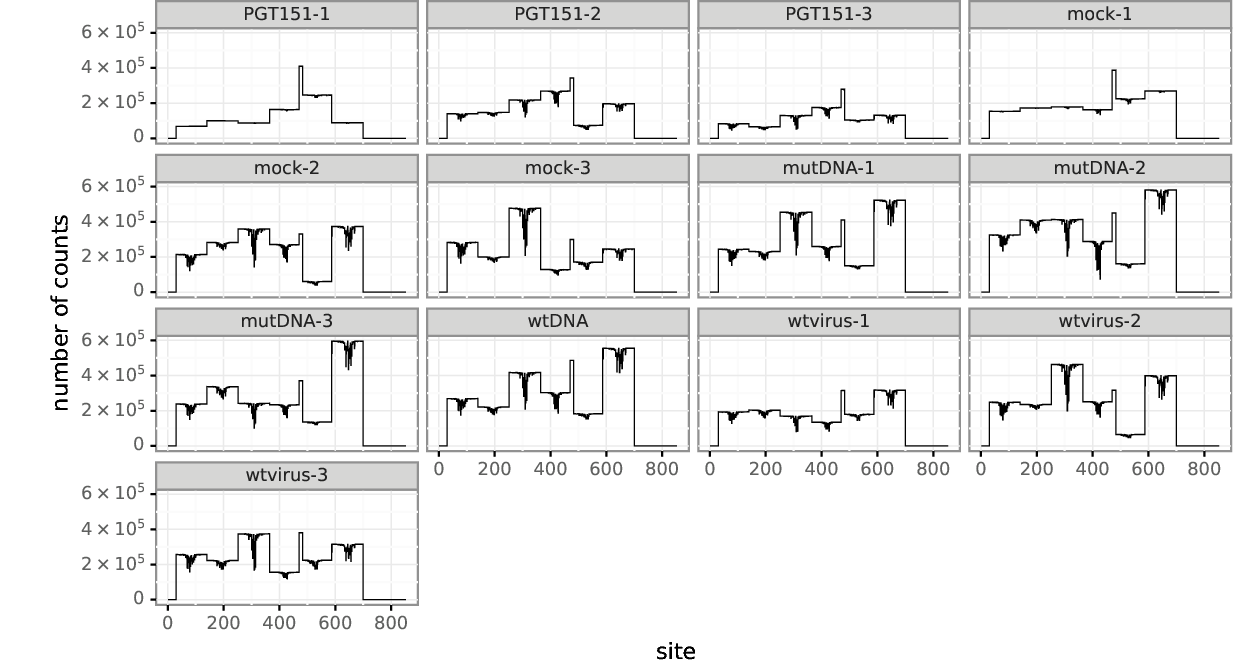

In [8]:
showPDF(countsplotprefix + '_depth.pdf')

The `*_mutfreq.pdf` plot below shows the per-codon frequency of mutations at each site. 
For each PGT151-selected sample, we see a few sites of clear peaks in mutation frequency. 
These peaks tend to occur at the same sites in different replicates, and so presumably represent the sites where antibody-escape mutations are selected. 
There are no such peaks for the mock sample since there is no antibody selection to favor specific mutations.
Note also that the gene was not mutagenized or sequenced past codon site 691, so there are no mutations there.

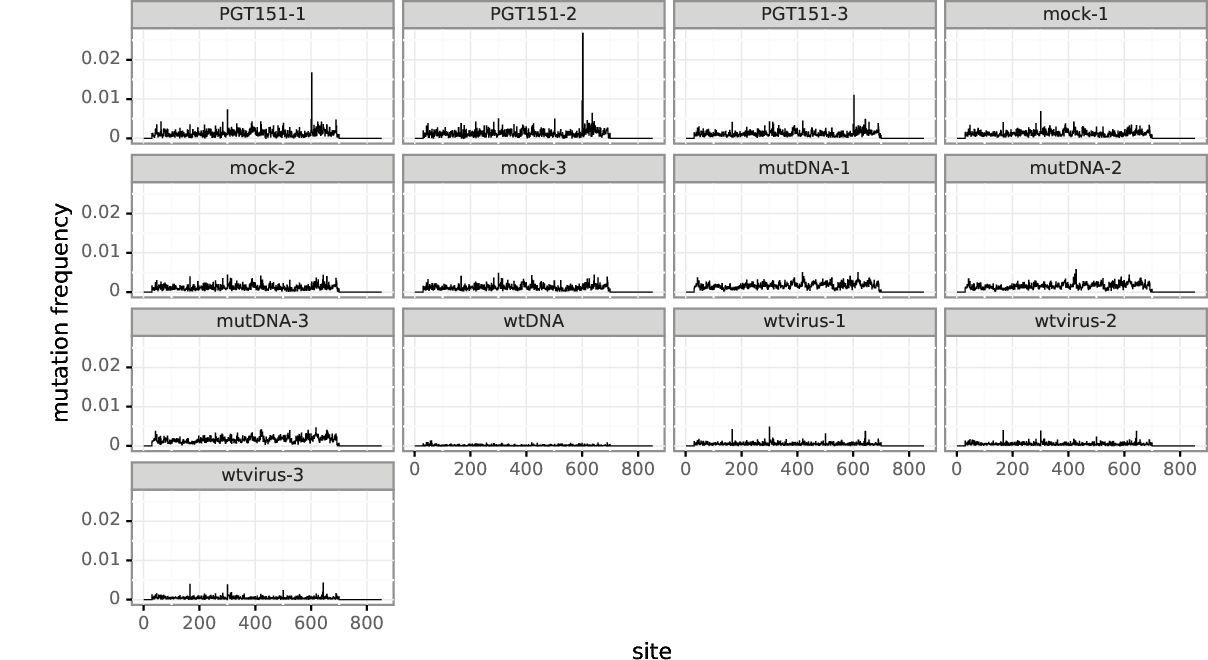

In [9]:
showPDF(countsplotprefix + '_mutfreq.pdf')

The `*_codonmuttypes.pdf` plot below shows the per-codon frequency of nonsynonymous, synonymous, and stop codon mutations across the entire gene. For the PGT151 selected samples, we see an overall increase in the per-codon mutation frequency due to very strong selection for variants with escape mutations.

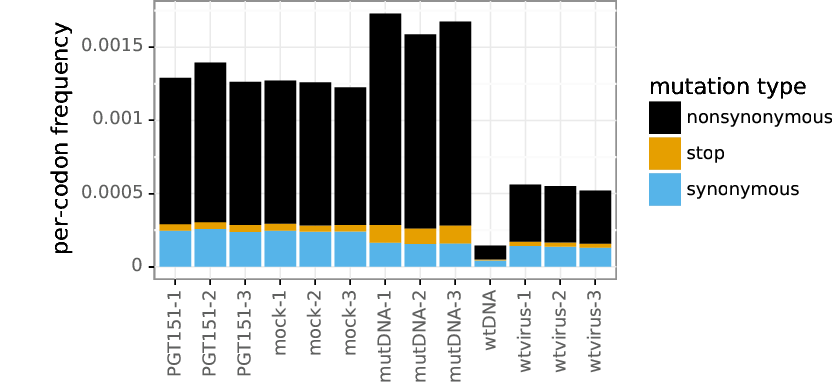

In [10]:
showPDF(countsplotprefix + '_codonmuttypes.pdf', width=600)

The `*_codonntchanges.pdf` plot below shows same data as above but categorizes codon mutations by the number of nucleotides that are changed (e.g., ATG to AAG changes 1 nucleotide, ATG to AAC changes 2 nucleotides, and ATG to CAC changes 3 nucleotides).

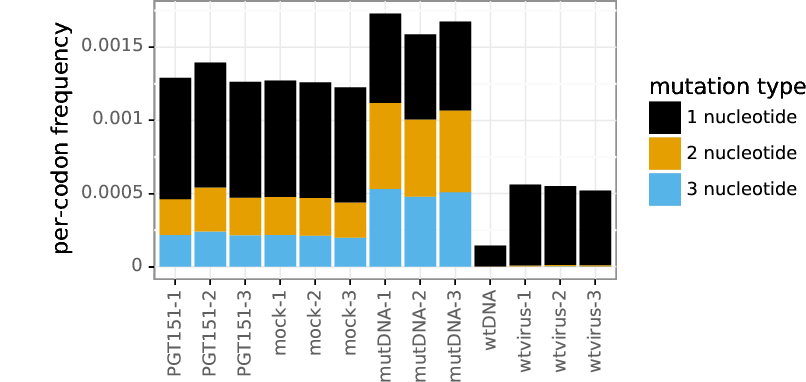

In [11]:
showPDF(countsplotprefix + '_codonntchanges.pdf', width=600)

The `*_singlentchanges.pdf` plot below shows the frequency of each type of nucleotide change among only codon mutations with one nucleotide change. This plot is mostly useful to check if there is a large bias in which mutations appear. In particular, if you are getting oxidative damage (which causes G to T mutations) during the library preparation process, you will see a large excess of C to A or G to T mutations (or both). There is not much oxidative damage in the samples plotted below, which mostly have a fairly even distribution of nucleotide changes.

We do see that transitions (G <-> A and C <-> T) are a bit more common than most of the other types of mutations (all of which are transversions). This is expected, since [PCR based sources of mutations are expected to preferentially introduce transitions](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3720931/). 

This plot would also be important to examine any sign of APOBEC hypermutation (also G <-> A, with preferences for specific motifs) occuring in the HIV genome. One of the reasons we selected the SupT1.R5 cell line was because [there is very little of the APOBEC proteins expressed in  a subclone of SupT1 cells](https://www.ncbi.nlm.nih.gov/pubmed/20308164). In the viral samples, there does appear to be an increase in G to A and C to T mutations. However, we passaged WT virus in these cells and confirmed there were not signs of extensive APOBEC hypermutation in hotspot motifs via deep sequencing of env after passaging. Thus, we do not think there is extensive APOBEC hypermutation in our data, and this increase certain types of mutations in the viral samples is likely due to bias in the viral reverse transcription.

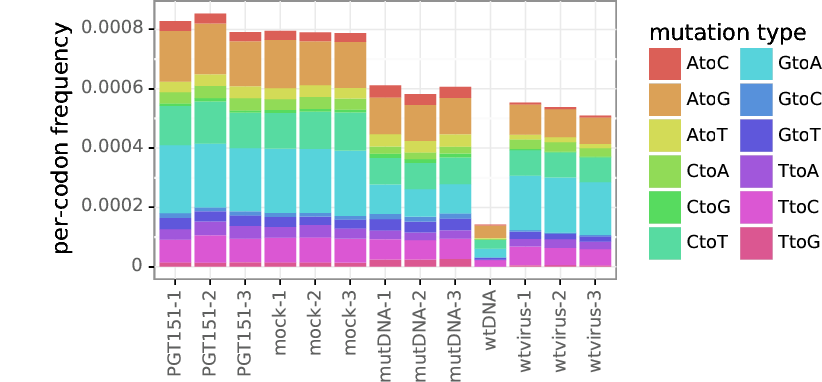

In [12]:
showPDF(countsplotprefix + '_singlentchanges.pdf', width=600)

## Renumber codon counts to HXB2 numbering 
The standard numbering scheme for HIV Env is the [HXB2 numbering scheme](https://www.hiv.lanl.gov/content/sequence/HIV/REVIEWS/HXB2.html).
The file [./data/BF520c2_to_HXB2.csv](./data/BF520c2_to_HXB2.csv) gives the mapping from sequential 1, 2, ... numbering of the BF520 protein sequence to the HXB2 numbering scheme. 
This file was generated by aligning the HXB2 sequence [taken from Genbank](http://www.ncbi.nlm.nih.gov/protein/1906385) with the BF520c2 sequence using the [LANL alignment interface](http://www.hiv.lanl.gov/cgi-bin/VIRALIGN/viralign.cgi) at the protein sequence level. 
Insertions relative to HXB2 are given letter suffixes as [described here](http://www.hiv.lanl.gov/content/sequence/HIV/REVIEWS/HXB2.html).

Additionally, not all residues in BF520 Env were mutagenized. 
The N-terminal signal peptide and the C-terminal cytoplasmic tail were excluded because they seem likely to affect expression level. 
These sites are not listed in the renumbering file, and so are dropped when we do the re-numbering.

To do the re-numbering, we use the [dms_tools2.utils.renumberSites](https://jbloomlab.github.io/dms_tools2/dms_tools2.utils.html#dms_tools2.utils.renumberSites) function from the [dms_tools Python API](https://jbloomlab.github.io/dms_tools2/api.html) to create a new directory that contains all of the re-numbered files with the same name as in the original codon counts directory produced above.

In [13]:
renumberfile = './data/BF520c2_to_HXB2.csv'

# renumbered counts will go here
renumberedcountsdir = os.path.join(resultsdir, 'renumberedcounts')

# counts files to renumber
countsfiles = glob.glob('{0}/*codoncounts.csv'.format(countsdir))

dms_tools2.utils.renumberSites(renumberfile, countsfiles, missing='drop', 
        outdir=renumberedcountsdir)

## Compute the differential selection and correlations between replicates
Now we compute the [differential selection](https://jbloomlab.github.io/dms_tools2/diffsel.html) from PGT151 antibody for each replicate, using the *wt-virus* controls to estimate the error rates.
We also compute the average differential selection across replicates.
Finally, we look at correlations between pairs of replicates in mutation and site differential selection, restricting to only positive differential selection.

We first create a batch file to use with [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html#dms2-batch-diffsel). 
Note we make the **group** argument the antibody, the **name** argument the replicate, and assign the **sel**, **mock**, and **err** arguments based on the names used for the batch file when generating the counts files above with `dms2_batch_bcsubamp`.
By grouping replicates for the same antibody in the batch file, we tell [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html#dms2-batch-diffsel) to analyze these together and take their mean and median.
All PGT151 selected samples were neutralized at 1 ug/mL of PGT151. 
We simply use 1ug to specify this concentration, as special characters (such as /) that are not allowed in the group argument. 
Note that we only have one group. 

In [14]:
# put diffsel values here
diffseldir = os.path.join(resultsdir, 'diffsel')
if not os.path.isdir(diffseldir):
    os.mkdir(diffseldir)
    
diffselbatchfile = os.path.join(diffseldir, 'batch.csv')

diffselbatch = pandas.DataFrame.from_records([
         # PGT151 at 1 ug/ml
         ('PGT151-1ug', 'replicate-1', 'PGT151-1', 'mock-1', 'wtvirus-1',), 
         ('PGT151-1ug', 'replicate-2', 'PGT151-2', 'mock-2', 'wtvirus-2',),
         ('PGT151-1ug', 'replicate-3', 'PGT151-3', 'mock-3', 'wtvirus-3',), 
        ],       
        columns=['group', 'name', 'sel', 'mock', 'err']
        )

print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(diffselbatch.to_html(index=False)))

diffselbatch.to_csv(diffselbatchfile, index=False)

Here is the batch file that we write to CSV format to use as input:


group,name,sel,mock,err
PGT151-1ug,replicate-1,PGT151-1,mock-1,wtvirus-1
PGT151-1ug,replicate-2,PGT151-2,mock-2,wtvirus-2
PGT151-1ug,replicate-3,PGT151-3,mock-3,wtvirus-3


Now we simply run [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html#dms2-batch-diffsel), getting the input counts from the directory (`--indir` argument) where we placed the re-numbered codon counts.

In [15]:
log = !dms2_batch_diffsel \
        --summaryprefix summary \
        --batchfile {diffselbatchfile} \
        --outdir {diffseldir} \
        --indir {renumberedcountsdir} \
        --use_existing {use_existing}

Running this command creates a large number of output files giving the mutation and site differential selection values in the formats of the `mutdiffsel.csv` and `sitediffsel.csv` files created by `dms2_diffsel`. These include:

In [16]:
!ls {diffseldir}/PGT151-1ug*.csv

./results/diffsel/PGT151-1ug-replicate-1_mutdiffsel.csv
./results/diffsel/PGT151-1ug-replicate-1_sitediffsel.csv
./results/diffsel/PGT151-1ug-replicate-2_mutdiffsel.csv
./results/diffsel/PGT151-1ug-replicate-2_sitediffsel.csv
./results/diffsel/PGT151-1ug-replicate-3_mutdiffsel.csv
./results/diffsel/PGT151-1ug-replicate-3_sitediffsel.csv


There are also files giving the mean and median differential selection for all samples in each group. 
These files are prefixed with the name given by `--summaryprefix` (in this case, summary), and also indicate the group:

In [17]:
!ls {diffseldir}/summary*PGT151-1ug*.csv

./results/diffsel/summary_PGT151-1ug-meanmutdiffsel.csv
./results/diffsel/summary_PGT151-1ug-meansitediffsel.csv
./results/diffsel/summary_PGT151-1ug-medianmutdiffsel.csv
./results/diffsel/summary_PGT151-1ug-mediansitediffsel.csv


Running [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html#dms2-batch-diffsel) creates plots showing how the differential selection estimates for each site / mutation correlate among replicates. 
These plots have names like `summary_PGT151-1ug-mutdiffselcorr.pdf`. 
Below we show the plots for mutdiffsel and positivesitediffsel (ones are also made for absolutesitediffsel and maxsitediffsel, but are not shown below as they are less informative for this experiment). 
Note that the plots show the correlations between all pairs, and also on the diagonal show the density of the different selection values for each replicates (most of them are close to zero).


mutdiffsel correlations:


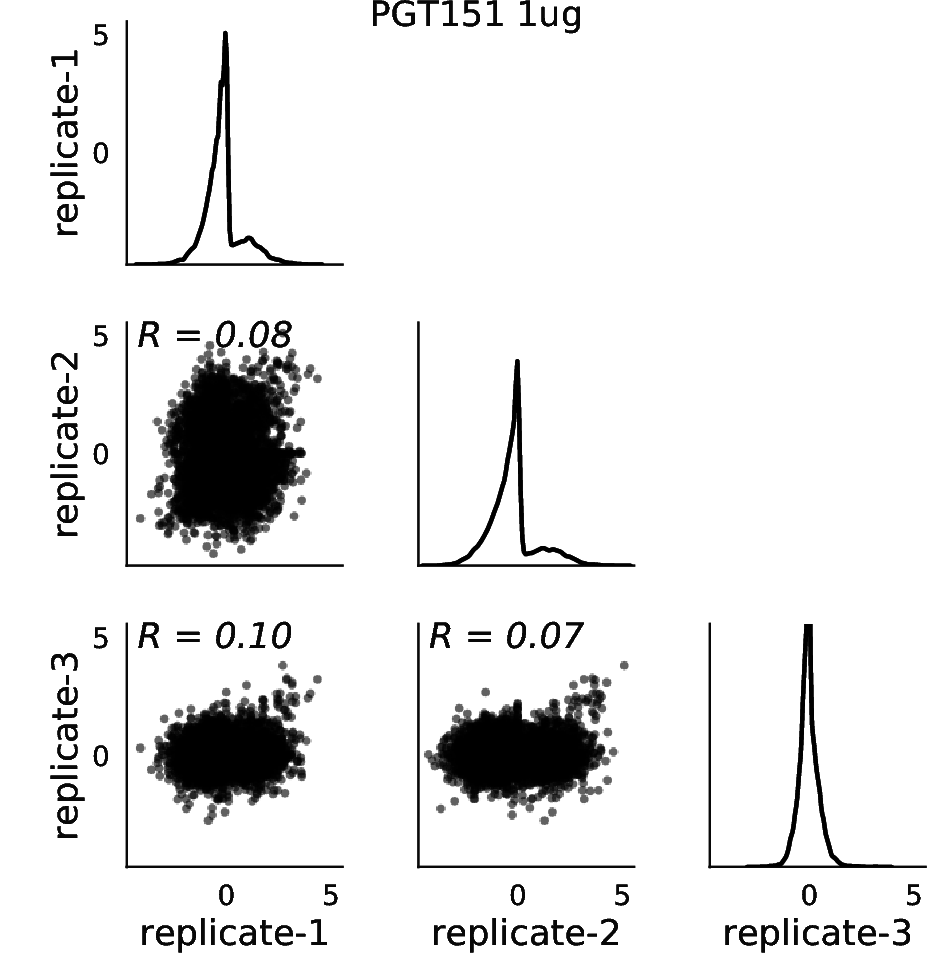


positivesitediffsel correlations:


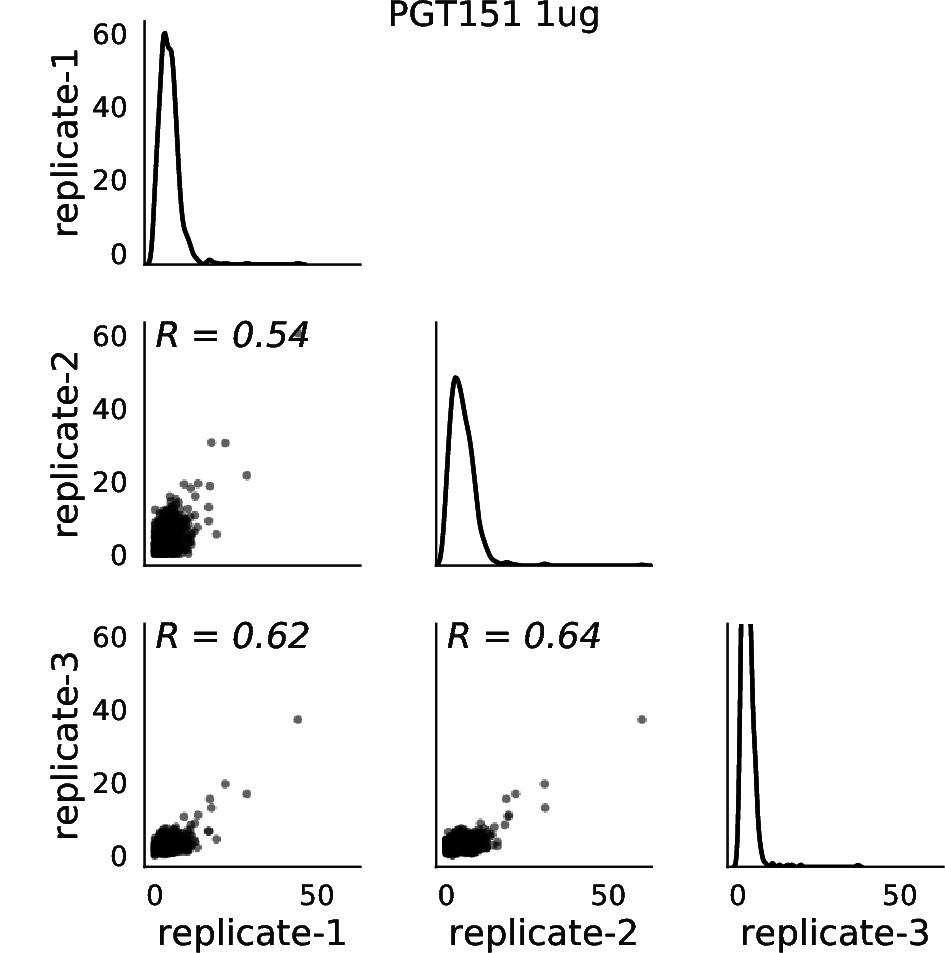

In [18]:
diffselprefix = os.path.join(diffseldir, 'summary_')
groups = diffselbatch['group'].unique()

for seltype in ['mutdiffsel', 'positivesitediffsel']:
    print("\n{0} correlations:".format(seltype))
    plots = []
    for g in groups:
        plot = diffselprefix + g + '-' + seltype + 'corr.pdf'
        plots.append(plot)
    showPDF(plots, width=400) 

Now we look at the differential selection along the primary sequence. Several plots showing this kind of selection are made by `dms2_batch_diffsel`. These plots show either the mean or the median differential selection among all samples in each group (CSV files have been created containing this differential selection as described above).

These files all have the prefix indicated by --summaryprefix, and show the positive differential selection, total site differential selection (both positive and negative), the maximum differential selection, and the minimum and maximum differential selection. Here are all the files created by this analysis:

In [19]:
!ls {diffseldir}/*diffsel.pdf

./results/diffsel/PGT151-1ug_diffsel.pdf
./results/diffsel/summary_meanmaxdiffsel.pdf
./results/diffsel/summary_meanminmaxdiffsel.pdf
./results/diffsel/summary_meanpositivediffsel.pdf
./results/diffsel/summary_meantotaldiffsel.pdf
./results/diffsel/summary_medianmaxdiffsel.pdf
./results/diffsel/summary_medianminmaxdiffsel.pdf
./results/diffsel/summary_medianpositivediffsel.pdf
./results/diffsel/summary_mediantotaldiffsel.pdf


For this particular experiment, the median and mean values look very similar, but for some experiments one might look a lot better than another if there are clear outlier measurements in some samples. For instance, below are the mean and median side-by-side for the total site differential selection (note how this plot shows both the positive and negative values, with the mean values at left and the median values at right):

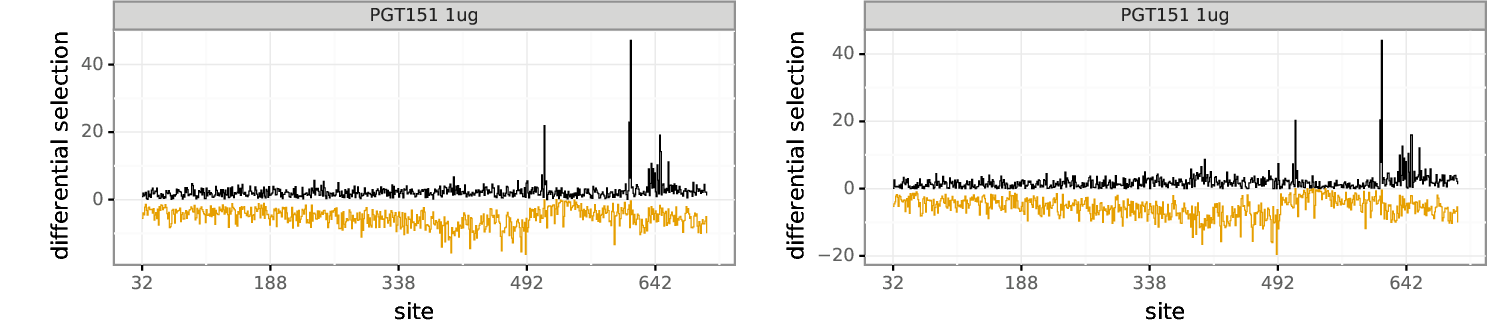

In [20]:
showPDF([diffselprefix + 'meantotaldiffsel.pdf', diffselprefix + 'mediantotaldiffsel.pdf'])

Probably the most informative plot is simply the mean positive site differential selection -- as shown in [Dingens et al, 2017](https://doi.org/10.1016/j.chom.2017.05.003). 
This plot shows the total positive selection for all mutations combined at a given site, and is shown below:

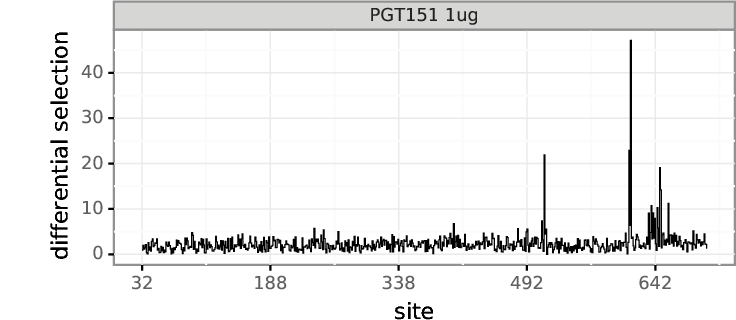

In [21]:
showPDF(diffselprefix + 'meanpositivediffsel.pdf', width=600)

Another plot that can sometimes be useful is the maximum mutation differential selection at each site. 
This measurement is more noisy, but it tells us how strong is the selection for the most favorable mutation at that site, so better detects sites where only one mutation might be substantially favored. 
Below we plot the mean and median maximum mutation-level measurements:

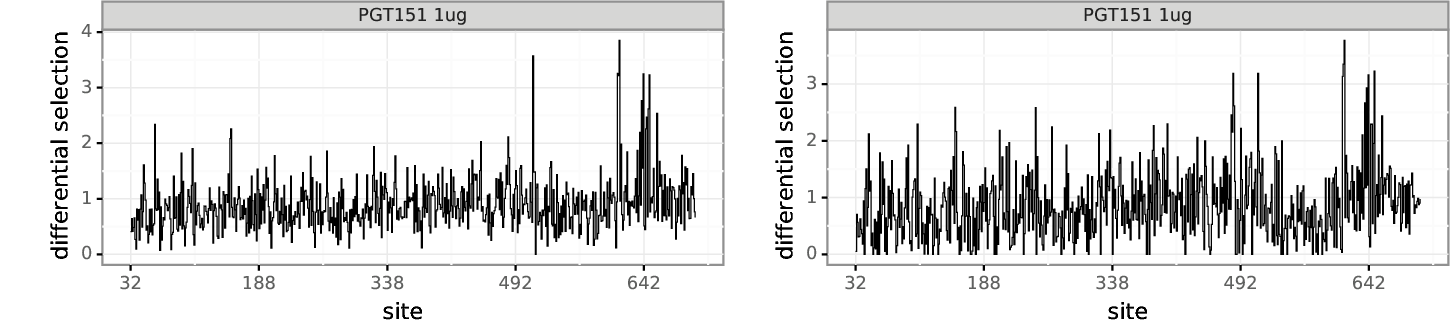

In [22]:
showPDF([diffselprefix + 'meanmaxdiffsel.pdf', diffselprefix + 'medianmaxdiffsel.pdf'])

## Make logo plots visualizing the differential selection 
The plots above summarize the site or maximum mutation differential selection using line plots. But the most comprehensive way to show this selection is in the form of logo plots that can be created with [dms2_logoplot](https://jbloomlab.github.io/dms_tools2/dms2_logoplot.html).

We make those logo plots using the mean mutation differential selection values returned by [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html). 

We also add underlays of the wildtype sequence and data from the original mapping of PGT151 done by [Falkowska et al 2014](http://www.sciencedirect.com/science/article/pii/S107476131400123X). 
In an impressive tour-de-force, they did TZM-bl neutralization of assays using large panels pseudoviruses bearing single mutants (usually to alanine) in two seperate viral strains, LAI and JR-CSF. 
In the underlays, if a box is colored at all, a mutation at that site was tested. 
It is colored according to the log2 fold-change in IC50 relative to wildtype imparted by that mutation. 
If multiple mutations were tested at a site, the mutation that results in a large change is used. 
Since the two strains had different maximum endpoints, we use the lower of the two (115-fold change) as the maximum effect of a single mutations, such that the effects are plotted on the same scale (this affects few sites). 
The effects of mutations in the JRCSF strain are in the file [./data/JRCSFalaninescandata_logbase2_115foldlimit.csv](./data/JRCSFalaninescandata_logbase2_115foldlimit.csv).
The effects of mutations in the LAI strain are in the file [./data/LAIalaninescandata_logbase2.csv](./data/LAIalaninescandata_logbase2.csv).

To add the wildtype sequence, we can simply specify an overlay file with the columns wildtype and site -- any of our mutdiffsel files suffice. 
Note that we use the `--underlay yes` option since underlays look better than overlays here.


Creating logo plot for PGT151-1ug from ./results/diffsel/summary_PGT151-1ug-meanmutdiffsel.csv


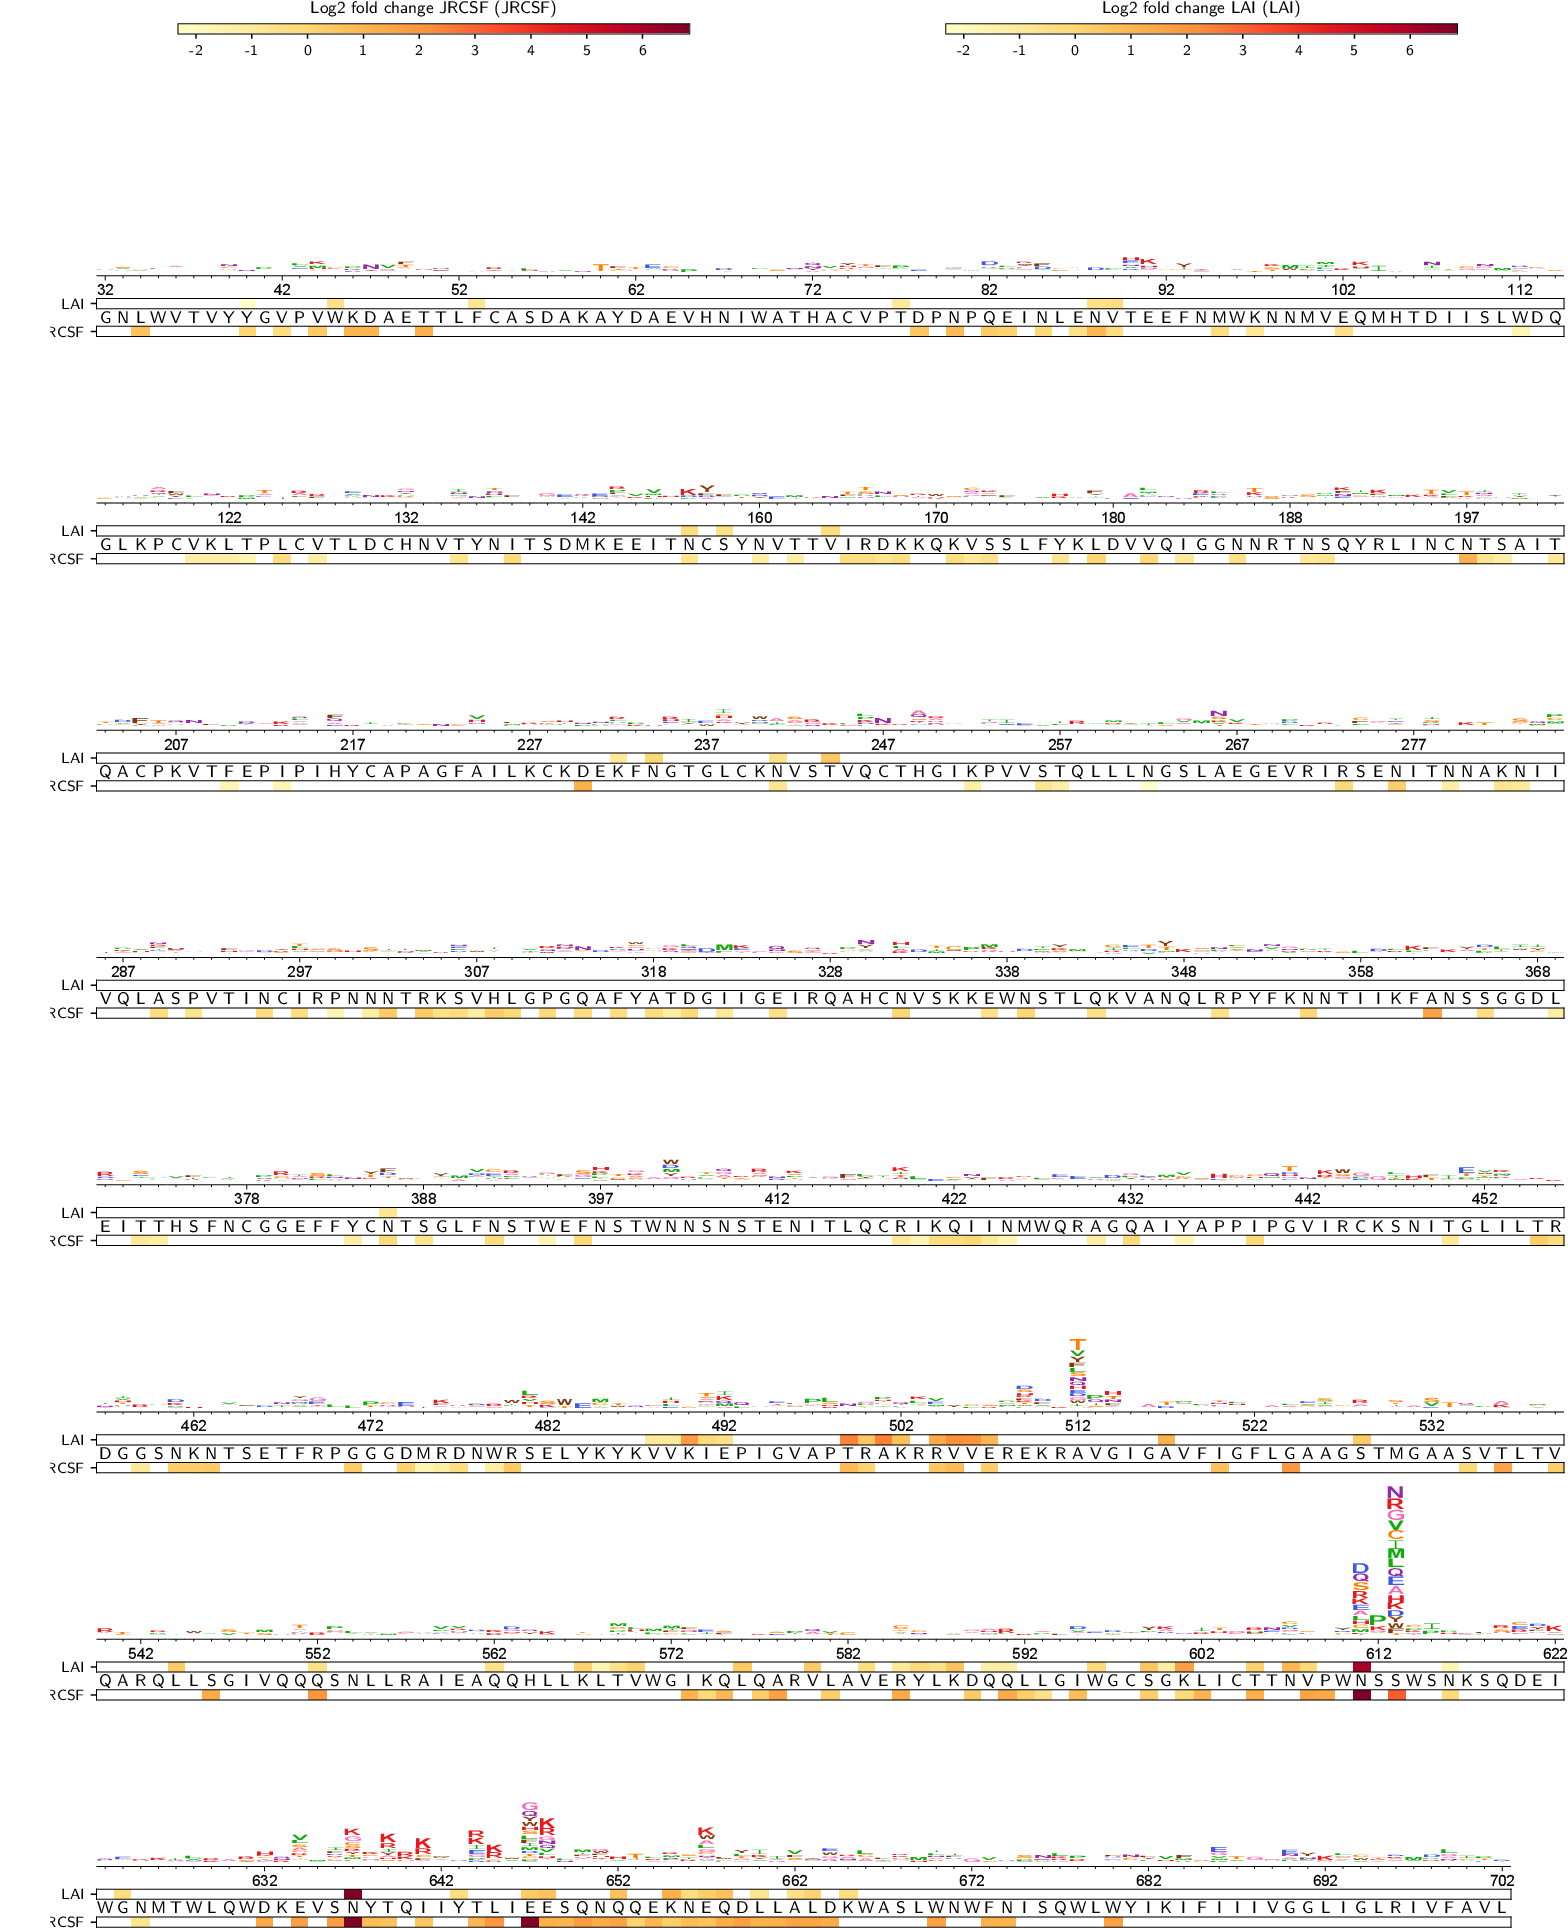

In [23]:
falkowska_lai = './data/LAIalaninescandata_logbase2.csv'
falkowska_jrcsf = './data/JRCSFalaninescandata_logbase2_115foldlimit.csv'

antibody = 'PGT151-1ug'
mutdiffsel = diffselprefix + antibody + '-meanmutdiffsel.csv'
logoplot = os.path.join(diffseldir, '{0}_diffsel.pdf'.format(antibody))

print("\nCreating logo plot for {0} from {1}".format(antibody, mutdiffsel))
log = !dms2_logoplot \
        --diffsel {mutdiffsel} \
        --name {antibody} \
        --outdir {diffseldir} \
        --restrictdiffsel positive \
        --sepline no \
        --nperline 83 \
        --overlaycolormap YlOrRd \
        --overlay1 {mutdiffsel} wildtype wildtype \
        --overlay2 {falkowska_lai} LAI "Log2 fold change LAI" \
        --overlay3 {falkowska_jrcsf} JRCSF "Log2 fold change JRCSF" \
        --underlay yes \
        --use_existing {use_existing}

showPDF(logoplot)